# Zyfra - Gold Recovery

Zyfra is company that specializes in developing artificial intelligence and IIoT-based solutions and robotic mining equiptment for heavy industry. One of Zyfra's clients is a gold mining/processing company, who has hired Zyfra to determine whether machine learning can identify ways to optimize the production of gold and eliminate unprofitable parameters. Out task is to prepare a prototype of a machine learning model, based on extraction and purification data, that predicts the amount of gold recovered from gold ore. In the following sections, we will prepare the data, train and test machine learning models, and compare the efficacy of the models with dummy models.

**Table of Contents:**
* [1 Import Libraries and Preprocess the Data](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Import Data](#1.2)
    * [1.3 Ensure Recovery is Correctly Calculated](#1.3)
    * [1.4 Identify Features not in Test Set](#1.4)
    * [1.5 Preprocess the Data](#1.5)
        * [1.5.1 Examine the Data](#1.5.1)
        * [1.5.2 Check for Duplicates](#1.5.2)
        * [1.5.3 Check for Rows Containing Missing Values](#1.5.3)
        * [1.5.4 Scale the Data](#1.5.4)
        * [1.5.5 Fill NaNs for Features & Drop Remaining Rows With NaNs](#1.5.5)
        * [1.5.6 Preprocessing Conclusion](#1.5.6)
* [2 Analyze the Data](#2)
    * [2.1 Examine Concentrations of Metals at Each Purification Stage](#2.1)
    * [2.2 Compare Feed Particle Size Distributions](#2.2)
    * [2.3 Compare Total Substance Concentrations at Different Stages](#2.3)
    * [2.4 Remove Outliers](#2.4)
        * [2.4.1 Select Outlier Rows From Main DataFrame](#2.4.1)
        * [2.4.2 Check New Distributions](#2.4.2)
        * [2.4.3 Remove Outliers from Training and Testing Datasets](#2.4.3)
    * [2.5 Data Analysis Conclusion](#2.5)
* [3 Build Models](#3)
    * [3.1 Create Functions to Calculate sMAPE & Final sMAPE](#3.1)
    * [3.2 Separate Features and Targets for Training and Testing Datasets](#3.2)
    * [3.3 Train and Evaluate Regression Models](#3.3)
    * [3.4 Use Cross Validation to Confirm Results](#3.4)
    * [3.5 Test the Best Model on Testing Datasets](#3.5)
    * [3.6 Check Score Against Sanity Check Model](#3.6)
* [4 Conclusion](#4)

## Import Libraries and Preprocess the Data<a class="anchor" id='1'></a>

### Import Libraries<a class="anchor" id='1.1'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### Import Data<a class="anchor" id='1.2'></a>

In [2]:
try:
    gold_train = pd.read_csv('D:\Programming\Yandex\Integrated Project 2/gold_recovery_train.csv')
    gold_test = pd.read_csv('D:\Programming\Yandex\Integrated Project 2/gold_recovery_test.csv')
    gold_full = pd.read_csv('D:\Programming\Yandex\Integrated Project 2/gold_recovery_full.csv')
except:
    gold_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
    gold_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
    gold_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

### Ensure Recovery is Correctly Calculated (Rougher)<a class="anchor" id='1.3'></a>

In [3]:
#Create function to calculate Recovery.
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

#Carry out calculations for rows which don't have NaN in rougher.output.recovery.
vals_pred = recovery(gold_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
vals_act = gold_train['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(vals_act, vals_pred)}")

1.3 Notes: In this subsection, we investigated whether recovery was correctly calculated for the rougher process. To do so, we created a function to calculate the recovery values based no a few key variables. The variables used in our function have the following meanings:

* C = Concentrate after process.
* F = Concentrate before process.
* T = Tails after process.

In carrying out our calculations, we made sure to ignore the NaNs. Once we calculated the recovery values, we calculated the Mean Absolute Error between our calculated results and those listed in the gold_train DataFrame. Our result was approximately 9.4e-15, which is so small that the difference between values is practically negligible for present purposes. 

### Identify Features not in Test Set<a class="anchor" id='1.4'></a>

In [4]:
#Use list comprehension to generate list of columns in gold_full that aren't in gold_test.
not_in_gold_test = [x for x in gold_full.columns if x not in gold_test.columns]
pprint(not_in_gold_test)

1.4 Notes: Our list shows that those columns not in the gold_test DataFrame include those whose values depend on the output of the floatation and cleaning processes. Most of these columns are likely not included in the testing dataset because they represent values that would not be known prior to the purification process being conducted. To include such features in the training dataset would lead to information leakage; as such, we will remove these columns from the training dataset in a later subsection. That being said, there are two variables that are not included in the testing dataset that should be - that is, the 'final.output.recovery' and 'rougher.output.recovery' variables, which are the targets of our investigation. We will merge these variables from the gold_full DataFrame into the gold_test DataFrame on 'date' so that we have our target values when testing our models in a later section. 

In [5]:
#Merge target values from gold_full into gold_test.
gold_test = pd.merge(gold_test, gold_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date', how='left')

#Drop features not in gold_test from gold_train.
gold_train = gold_train.drop(columns=[x for x in gold_train if x not in gold_test], axis=1)

#Drop features in gold_test not in gold_train.
gold_test = gold_test.drop(columns=[x for x in gold_test if x not in gold_train], axis=1)

### Preprocess the Data<a class="anchor" id='1.5'></a>

#### Examine the Data<a class="anchor" id='1.5.1'></a>

In [6]:
print(gold_test.info())
print()
print(gold_train.info())

1.5.2 Notes: From the above information on the gold_test and gold_train DataFrames, we can see that there are the same number of columns in each DataFrame. Both also have one column whose values are of the 'object' data type; since this column's values are meant to represent dates and times, which are unimportant to our later analyses, we will drop this column from both DataFrames, rather than change the data type, in a later section. The remaining columns' values in each DataFrame are of the 'float64' data type, and none of the columns appear to represent boolean variables; as such, we will not need to encode these variables for our later analyses.

One important takeaway from the above information is that each DataFrame contains NaNs. We will calculate the number of rows with NaNs and attempt to fill these missing values in a later subsection.

#### Check for Duplicates<a class="anchor" id='1.5.2'></a>

In [7]:
print(f"Duplicates in the gold_train dataset: {gold_train.duplicated().sum()}")
print(f"Duplicates in the gold_test dataset: {gold_test.duplicated().sum()}")

#### Check for Rows Containing Missing Values<a class="anchor" id='1.5.3'></a>

In [8]:
print(f"Rows with NaNs in the gold_train dataset: {gold_train.isnull().any(axis=1).sum()}")
print(f"Rows with NaNs in the gold_test dataset: {gold_test.isna().any(axis=1).sum()}")

1.5.3 Notes: Because there are so many NaNs in the DataFrames, we cannot simply drop them. As such, we will fill the NaNs. One popular method for fillins NaNs involves grouping data according to specific features and filling the NaNs on this basis; we have opted not to go this route, as there are many features in the dataset and a features value may be intimately tied to the values of other features in a way that we cannot manually replicate in a concise manner. Another option is to use ffill or bfill, which fills each NaN with their respective preceding or following value; we also opted not to use this method, as it ignores any correlations between the variable with the NaN and other variables. 

That being said, we will fill the NaNs using the k-Nearest Neighbor method. In doing so, we use sklearn's KNNImputer, which imputes missing values in datasets by finding the nearest neighbors using a Euclidean distance matrix. We believe that this method would provide us with the most accurate estimation of a NaNs value. Before filling the NaNs using the KNNImputer, we need to scale the values; this is important, as KNN is a distance-based algorithm that is affected by the scale of variables. As such, in order to not provide more weight to one variable over another, we will scale the data.

#### Scale the Data<a class="anchor" id='1.5.4'></a>

In [9]:
#Create a MinMaxScaler instance.
scaler = MinMaxScaler()

#Create lists for columns to scale and not to scale.
scale_columns = [x for x in gold_train.columns if x  not in ['date', 'rougher.output.recovery', 'final.output.recovery']]
non_scale_columns = ['date', 'rougher.output.recovery', 'final.output.recovery']

#Scale data in scale_columns for training and testing datasets.
gold_train_scaled = pd.DataFrame(scaler.fit_transform(gold_train[scale_columns].copy()), columns = scale_columns)
gold_test_scaled = pd.DataFrame(scaler.transform(gold_test[scale_columns].copy()), columns = scale_columns)

1.5.4 Notes: In this subsection we normalized our data. To do so, we created an instance of the MinMaxScaler class, which transforms all values into numbers between 0 and 1 (at least, on the dataset that the scaler it fit to). We fit the scaler to our training dataset, and then we transformed both our training and testing datasets. We will use these normalized datasets when training and testing our models in a subsequent section; by using normalized data, we are able to ensure that all features are given equal weight. 

#### Fill NaNs for Features & Drop Remaining Rows With NaNs<a class="anchor" id='1.5.5'></a>

In [10]:
%%time
#Create instance of KNNImputer class.
imputer = KNNImputer()

#Scale values in both DataFrames and add the 'date' column back to each.
gold_train_scaled = pd.concat([gold_train[non_scale_columns]] + \
                              [pd.DataFrame(imputer.fit_transform(gold_train_scaled), \
                               columns=gold_train_scaled.columns)], axis = 1)

gold_test_scaled = pd.concat([gold_test[non_scale_columns]] + \
                             [pd.DataFrame(imputer.transform(gold_test_scaled), \
                              columns=gold_test_scaled.columns)], axis = 1)

In [11]:
#Print count for remaining rows with NaNs in each dataset.
print(f"Rows with NaNs in the gold_train_scaled dataset: {gold_train_scaled.isnull().any(axis=1).sum()}")
print(f"Percent of rows with NaNs in one or both targets in gold_train_scaled dataset: {round(100 * (gold_train_scaled.isnull().any(axis=1).sum()) / len(gold_train_scaled), 2)}\n")
print(f"Rows with NaNs in the gold_test_scaled dataset: {gold_test_scaled.isna().any(axis=1).sum()}")
print(f"Percent of rows with NaNs in one or both targets in gold_test_scaled dataset: {round(100 * (gold_test_scaled.isnull().any(axis=1).sum()) / len(gold_test_scaled), 2)}")

In [12]:
#Drop rows with NaNs in target columns.
gold_train_scaled = gold_train_scaled.dropna().reset_index(drop=True)
gold_test_scaled = gold_test_scaled.dropna().reset_index(drop=True)

1.5.5 Notes: In this subsection we used the KNNImputer to fill in NaNs in both the gold_train_scaled and gold_test_scaled DataFrames. In order to prevent any data from the test set influencing the training set, we fit the imputer to the training set and then used that model to fill in NaNs in the test set. Importantly, we did not use the imputer on the targets, as this may artificially increase the relationship of the target values with independent variables and distort a model's test scores. This means that there were NaNs left over in the target columns of our datasets. Since we are not able to impute the missing target values without potentially affecting our future models' scores, we decided to drop the remaining rows with NaNs from our datasets. While this accounts for approximately 16 percent of our training dataset and 10 percent of our testing dataset, we have enough values in each set remaining to train and test models.

#### Preprocessing Conclusion<a class="anchor" id='1.5.6'></a>

In this section, we preprocessed the data in the training and testing datasets. In doing so, we found that all columns other than the 'date' column in each DataFrame are of the 'float64' format; since none of these columns appeared to denote boolean variables, we did not have to encode any of the variables. We also checked for NaNs in both DataFrames. Finding that there were many, instead of dropping rows with NaNs we used the KNNImputer to fill in the missing values. In doing so, we fit the imputer to the training dataset and transformed both the training and testing datasets accordingly; we followed this procedure in order to prevent any influence of the testing dataset on the training dataset. 

In the following section, we will analyze our data.

## Analyze the Data<a class="anchor" id='2'></a>

### Examine Concentrations of Metals at Each Purification Stage<a class="anchor" id='2.1'></a>

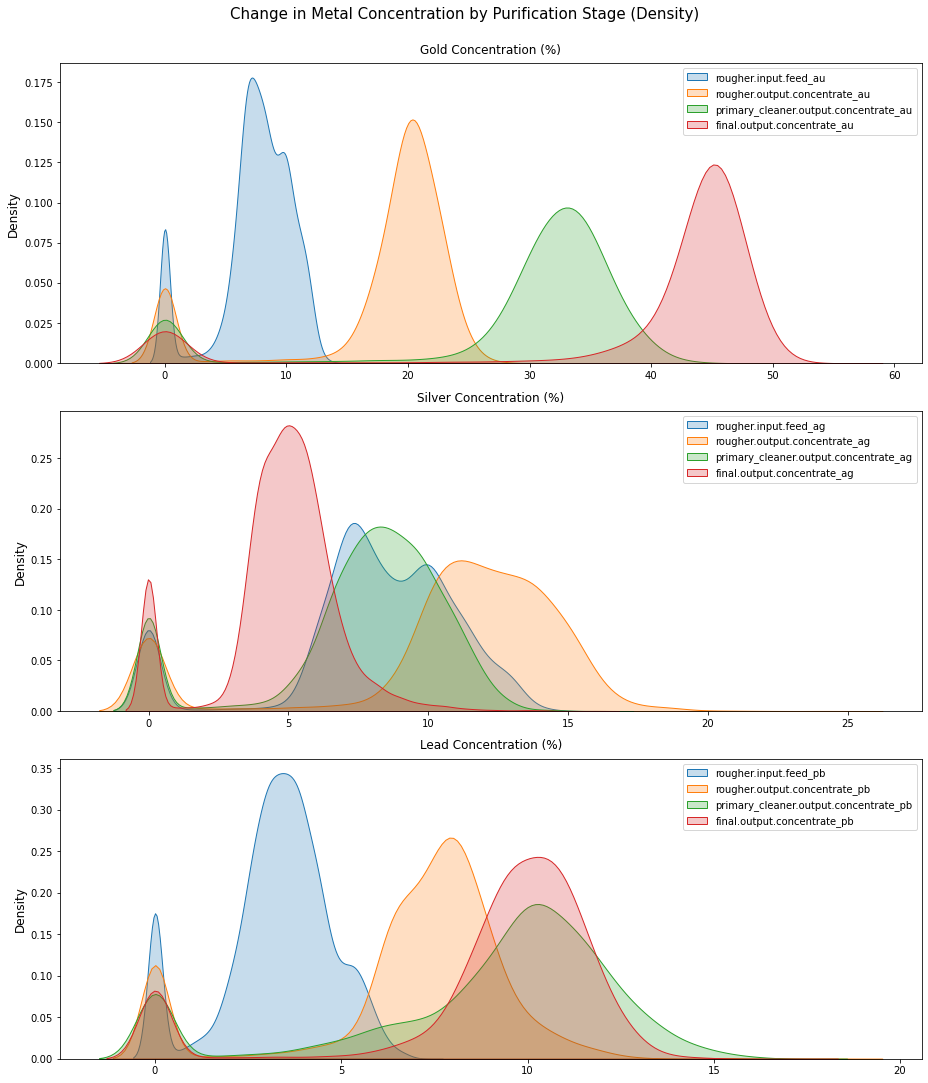

In [13]:
#Create list of variable handles to examine for each metal.
concen = ["rougher.input.feed", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate"]

#Create dictionary to map each metal's unique variable identifier with it's name.
metals = {'_au' : 'Gold', '_ag' : 'Silver', '_pb' : 'Lead'}

#Create subplots to visualize each metals concentration after each purification stage.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 15), sharey=False)
fig.suptitle('Change in Metal Concentration by Purification Stage (Density)', fontsize=15, y=1)

for x in metals.keys():
    for c in concen:
        ax = list(metals.keys()).index(x)
        sns.kdeplot(gold_full[(c+x)], ax=axes[ax], shade='fill', label=(c+x))
        axes[ax].legend()
        axes[ax].set_xlabel(metals[x] + ' Concentration (%)', fontsize=12, labelpad = 10)
        axes[ax].xaxis.set_label_position('top')
        axes[ax].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

2.1 Notes: In this subsection we used the gold_full dataset to examine the concentrations of each metal at key steps in the purification process. Based on the kernel density plots, we can conclude the following:

* Gold: At every step of the purification process, the concentration of gold increases. This is exactly what you'd want to see from a gold extraction endeavor.


* Silver: Interestingly, after flotation the concentration of silver increases, but then it decreases after each subsequent process. The end result is a concentration of silver lower than the concentration in the initial ore mixture.


* Lead: It appears that the concentration of lead increases until the second stage cleaner process, where is remains roughly equal to the concentration after the primary cleaner process.

It appears that there are outliers in the relevant data. For each stage in the process, we see that there are instances where each metals' concentration is 0. This may be due to a lack of the metal in the initial ore, or a problem with the data. In the subsequent subsections we will visualize more data and ultimately determine how to deal with the outliers.

### Compare Feed Particle Size Distributions <a class="anchor" id='2.2'></a>

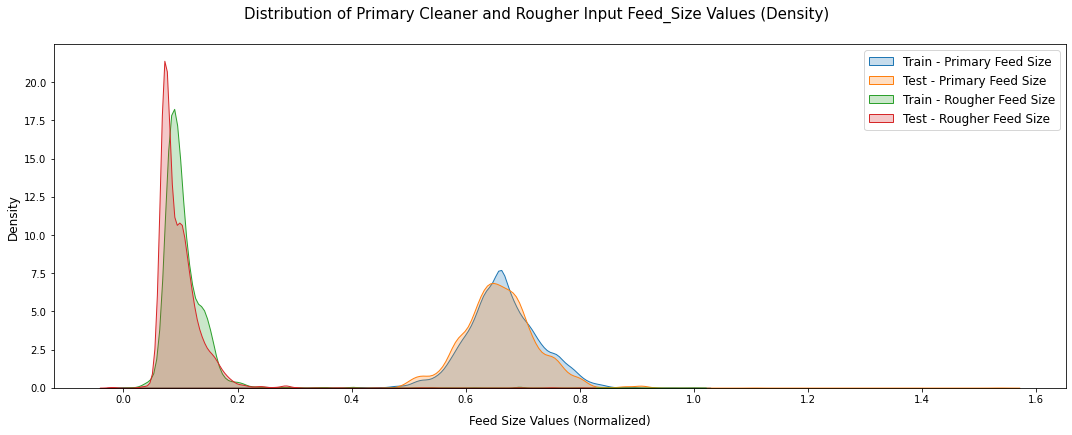

In [14]:
#Create plot to visualize key feed_size value distributions for training and testing datasets.
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Distribution of Primary Cleaner and Rougher Input Feed_Size Values (Density)', fontsize=15, y=1)

sns.kdeplot(gold_train_scaled['primary_cleaner.input.feed_size'], fill=True, label='Train - Primary Feed Size')
sns.kdeplot(gold_test_scaled['primary_cleaner.input.feed_size'], fill=True, label='Test - Primary Feed Size')
sns.kdeplot(gold_train_scaled['rougher.input.feed_size'], fill=True, label='Train - Rougher Feed Size')
sns.kdeplot(gold_test_scaled['rougher.input.feed_size'], fill=True, label='Test - Rougher Feed Size')
plt.legend(fontsize=12)
plt.xlabel('Feed Size Values (Normalized)', fontsize=12, labelpad = 10)
plt.ylabel('Density', fontsize=12)
    
plt.tight_layout()
plt.show()

2.2 Notes: As we can see from the above plot, the distributions of values for 'primary_cleaner.input.feed_size' and 'rougher.input.feed_size' are roughly the same for the training and testing datasets. This is good, as widely differing distributions of key features between training and testing datasets might negatively affect a model's performance.

It's worth noting here that the feed sizes displayed on the plot are not the actual values from the original datasets; rather, they are the scaled values that we obtained after normalizing the data in subsection 1.5.4.

### Compare Total Substance Concentrations at Different Stages<a class="anchor" id='2.3'></a>

In [15]:
#Create function to get total concentration of all metals at certain stages.
def metal_concen_sum(df, stage):
    metal_handles = list(metals.keys())
    total_concen = df[stage+metal_handles[0]] + df[stage+metal_handles[1]] + df[stage+metal_handles[2]]
    return total_concen

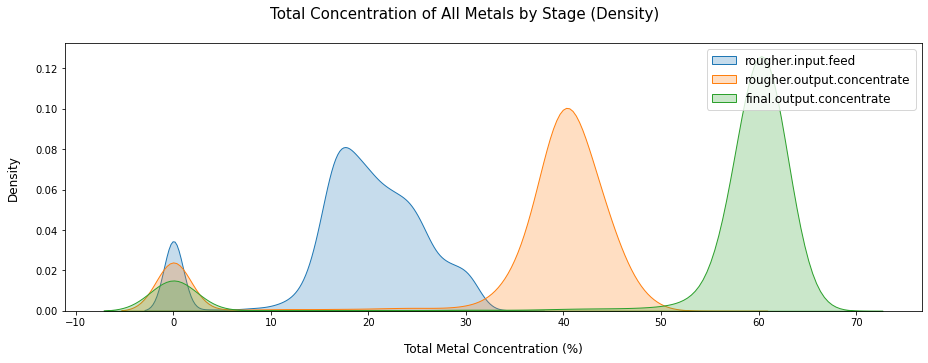

In [16]:
#Create plot to visualize total concentration of all metals at certain stages.
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(gold_full, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(gold_full, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(gold_full, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

2.3 Notes: The above plot shows the kernel density estimation for the distribution of total metal concentrations for each stage of the purification process. As we can see, the total concentration for all metals increases, for the most part, at each stage of the purification process. There are, however, clear outliers, which are represented by the values grouped around 0. In order to ensure that these outliers do not negatively affect the models we will train in a later section, we will remove the outliers from our training and testing datasets. Based on the plot, we believe a good cutoff concentration value is 10 for each stage. Since the values in our training and testing datasets have been normalized, we cannot simply filter the datasets by summing the relevant values and selecting only those rows where the value is greater that 10. Instead, we will filter these outliers from the gold_full DataFrame, then remove these rows from the other datasets using the 'date' indexer.

### Remove Outliers<a class="anchor" id='2.4'></a>

#### Select Outlier Rows From Main DataFrame<a class="anchor" id='2.4.1'></a>

In [17]:
gold_full_no_outliers = gold_full.loc[(gold_full[['rougher.input.feed_au', 'rougher.input.feed_pb', \
                                               'rougher.input.feed_ag']].sum(axis=1) > 10) \
                                  & (gold_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_pb', \
                                                 'rougher.output.concentrate_ag']].sum(axis=1) > 10) \
                                  & (gold_full[['final.output.concentrate_au', 'final.output.concentrate_pb', \
                                                'final.output.concentrate_ag']].sum(axis=1) > 10)]

#### Check New Distributions<a class="anchor" id='2.4.2'></a>

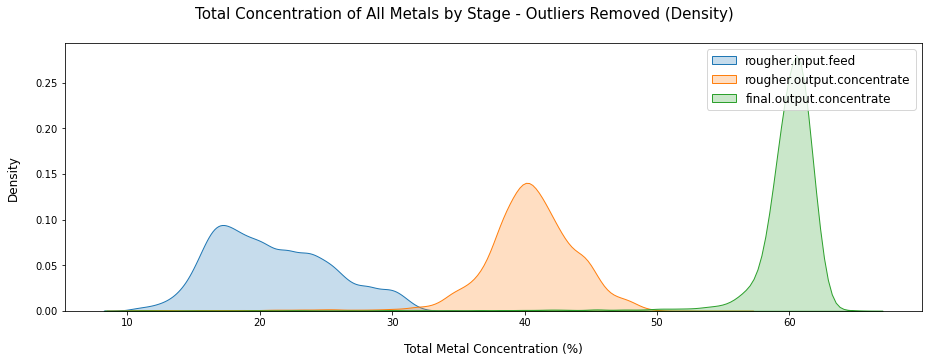

In [18]:
#Create plot to visualize total concentration of all metals at certain stages in dataset with outliers removed.
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage - Outliers Removed (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(gold_full_no_outliers, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(gold_full_no_outliers, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(gold_full_no_outliers, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

2.4.2 Notes: As we can see from the above plot, we have successfully removed the outliers. We stored the filtered gold_full DataFrame in the gold_full_no_outliers variable. We will now ensure that only those rows listed in this filtered DataFrame are present in the training and testing datasets. To do so, we will remove any row from the training and testing datasets where the 'date' value is not present in gold_full_no_outliers.

#### Remove Outliers from Training and Testing Datasets<a class="anchor" id='2.4.3'></a>

In [19]:
total_before = [len(gold_train_scaled), len(gold_test_scaled)]

#Remove outliers from scaled testing and training datasets based on whether date is in gold_full_no_outliers.
gold_train_scaled = gold_train_scaled.loc[gold_train_scaled['date'].isin(gold_full_no_outliers['date'])].reset_index(drop=True)
gold_test_scaled = gold_test_scaled.loc[gold_test_scaled['date'].isin(gold_full_no_outliers['date'])].reset_index(drop=True)

#Display lengths of datasets before and after removing outliers, as well as percentage of difference.
display(pd.DataFrame([[total_before[0], len(gold_train_scaled), round((100 - (len(gold_train_scaled) / total_before[0]) * 100), 2)], \
                      [total_before[1], len(gold_test_scaled), round((100 - (len(gold_test_scaled) / total_before[1]) * 100), 2)]], \
                    columns = ['Initial Length', 'New Length', 'Difference (%)'], index=['Gold Train', 'Gold Test']))

### Data Analysis Conclusion<a class="anchor" id='2.5'></a>

In this section we analyzed out data using the training, testing, and full datasets. The overall goal of this analysis was to determine whether there exist outliers that might have a negative impact on our later models; additionally, we wanted to determine whether the distribution of rougher.feed_size values were similar for the training and testing datasets, as widely differing distributions could also negatively affect our models. 

Based on our analyses, we found that the distributions of rougher.feed_size values are similar for the training and testing datasets. We also found that there are outliers concerning the concentration of metals at different stages in the purification process. Most notably, we found that when summing the concentration of all metals at key steps in the purification process, there are many values that appear to be 0, or approximately 0. Based on our kde plot, we can see that these are clearly outliers. 

In order to remove the outliers from our training and testing datasets, we first filtered the outliers from the gold_full DataFrame and saved the results in a new variable. We then used the .isin() function to ensure that only those data points that are listed in the outlier-free dataset are present in the training and testing datasets. We were able to use this method because the data points are indexed by 'date' values; as such, we were able to check whether the 'date' values in the training and testing datasets are in the outlier-free dataset and drop those data points that fail this condition.

In the next section, we will create a function to calculate the sMAPE (Symmetric Mean Absolute Percentage Error) metric. We will then train and test models with the goal of predicting the amount of gold recovered from gold ore.

## Build Models<a class="anchor" id='3'></a>

### Create Functions to Calculate sMAPE & Final sMAPE<a class="anchor" id='3.1'></a>

In [20]:
#Create function to calculate sMAPE.
def smape2(y_true, y_pred):
    smape = np.mean(abs(y_pred - y_true) / ((abs(y_true) + abs(y_pred)) / 2)) * 100 
    return smape

#Create function to calculate final sMAPE.
def f_smape(y_true, y_pred):
    predicted_rough, predicted_final = y_pred[:, 0], y_pred[:, 1]
    true_rough, true_final = y_true[:, 0], y_true[:, 1]
    f_smape = (.25 * (smape2(true_rough, predicted_rough))) + (.75 * (smape2(true_final, predicted_final)))
    return f_smape

### Separate Features and Targets for Training and Testing Datasets<a class="anchor" id='3.2'></a>

In [21]:
#Get list of feature and training columns.
targets = ['rougher.output.recovery', 'final.output.recovery']
features = [x for x in gold_train_scaled if x not in targets and x != 'date']

#Split training and testing datasets by features and targets.
y_train, y_test = gold_train_scaled[targets].values, gold_test_scaled[targets].values
X_train, X_test = gold_train_scaled[features].values, gold_test_scaled[features].values

### Train and Evaluate Regression Models<a class="anchor" id='3.3'></a>

In [22]:
#Create scorer for GridSearchCV.
smape = make_scorer(f_smape, greater_is_better=False)

#Create function to train and fit models using GridSearchCV
def train_fit_score(model, params, name):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=smape, verbose=0, refit=True)
    model.fit(X_train, y_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [23]:
%%time
#Create Decision Tree Regressor
DecisionTree = train_fit_score(DecisionTreeRegressor(random_state=12345), \
                      {'max_depth': range(5, 10, 5), \
                       'min_impurity_decrease' : np.arange(.01, .20, .02), \
                       'min_samples_split' : range(1, 10, 2)}, 'Decision Tree')

In [24]:
%%time
#Create Linear Regressor
LinearRegressor = train_fit_score(LinearRegression(), {}, 'Linear Regressor')

In [25]:
%%time
#Create Lasso Regressor
LassoRegressor = train_fit_score(Lasso(random_state=12345), \
                        {'alpha' : np.arange(.01, 1, .05)}, 'Lasso Regressor')

In [26]:
%%time
#Create KNeighbors Regressor
KNNeighbors = train_fit_score(KNeighborsRegressor(), 
                        {'n_neighbors' : range(2, 10, 1),
                         'weights' : ['uniform', 'distance']}, 'KNeighbors Regressor')

In [27]:
%%time
#Create Random Forest Regressor
RandomForest = train_fit_score(RandomForestRegressor(random_state=12345), 
                       {'n_estimators' : range(10, 100, 20),
                        'max_depth' : range(5, 60, 5),
                        'min_impurity_decrease' : np.arange(.05, .20, .05)}, 'Random Forest')

In [28]:
#Display best scores from all regressors.
scores = pd.concat([DecisionTree, LinearRegressor, LassoRegressor, KNNeighbors, RandomForest]).set_index('Estimator')
scores['Best Score'] = scores['Best Score'].round(2)
display(scores.drop('Best Params', axis=1))

3.3 Notes: In this subsection we trained 5 different regression models and obtained the sMAPE scores using the predictions of each model. In doing so, we used GridSearchCV to iterate through a series of hyperparameters for each model; as also specified that GridSearchCV use the sMAPE function we created for scoring and return the score for the model with the lowest average sMAPE score. Based on our results, it appears that the Lasso Regressor performs the best, with an average symmetric mean absolute percentage error of approximately 8.51. In the following subsection, we will attempt to confirm these results by using sklearn's 'cross_val_score' function.  

### Use Cross Validation to Confirm Results<a class="anchor" id='3.4'></a>

In [29]:
#Create list of estimators with parameters selected from the best_params_ values for each estimator. 
regressors = [DecisionTreeRegressor(**scores['Best Params'][0]), LinearRegression(**scores['Best Params'][1]), \
              Lasso(**scores['Best Params'][2]), KNeighborsRegressor(**scores['Best Params'][3]), \
              RandomForestRegressor(**scores['Best Params'][4])]

#Create list for final cross validation scores.
cv_scores = []

#Loop through models to obtain average cross validation score for each using 5 folds and sMAPE for scoring. 
for regressor in regressors:
    temp_score = abs(cross_val_score(regressor, X_train, y_train, cv=5, scoring=smape, verbose=0))
    cv_scores.append(round(np.mean(temp_score), 2))

In [30]:
#Display scores from cross validation
display(pd.DataFrame(cv_scores, columns=['Cross Val. Scores'], index=scores.index))

3.4 Notes: As we can see, the results we obtained from using cross validation are the same, when rounded to the second decimal place, as the scores we received from the models we trained. In obtaining these scores, we used sklearn's cross_val_score function and ran 5-fold cross validation on all of the previously used estimators; in doing so, we passed each estimator the parameters that we found provided the best sMAPE score. That we obtained the same sMAPE scores as previously was expected; this is because GridSearchCV used 5-fold cross validation in iterating through the various combinations of hyperparameters to find the best model. 

In the next subsection, we will use the model that provided us with the best sMAPE score (i.e., Lasso Regressor) on our testing datasets.

### Test the Best Model on Testing Datasets<a class="anchor" id='3.5'></a>

In [31]:
#Create instance of best KNeighbors regression model and fit it to training data.
best_model = Lasso(**scores['Best Params'][2]).fit(X_train, y_train)

#Obtain final sMAPE score for model using testing datasets.
Lasso_smape = round(f_smape(y_test, best_model.predict(X_test)), 2)

#Print the result.
print(f'sMAPE score for best Lasso Regressor model on test datasets: {Lasso_smape}')

3.5 Notes: In this subsection we used the Lasso regressor with the optimal parameters we identified to calculate the model's sMAPE score using the testing datasets. As it turns out, the sMAPE score for the testing datasets is better than the score for the training datasets. Our score of approximately 6.28 tells us that the model's forecast is off by an average of around 6 percent. Whereas this appears good, we cannot determine whether the value is indeed good without checking it against the sMAPE score of a naive forecasting model. As such, in the next section we will build a dummy regressor and check our sMAPE score against the score for a sanity check model.

### Check Score Against Sanity Check Model<a class="anchor" id='3.6'></a>

In [32]:
#Build sanity 'model' and obtain sMAPE score.
smape_sanity = f_smape(y_test, np.tile(np.mean(y_train, axis=0), (len(y_test), 1)))
print(f'sMAPE score for sanity check model: {round(smape_sanity, 2)}')

3.6 Notes: In this section we 'trained' our sanity 'model' using the training dataset; in doing so, we changed the target values to the average value for each target. As it turns out, the sanity 'model's' score is slightly higher than our best model's score. Though the difference isn't very much, it does show that our Lasso Regressor is a step in the right direction.

## Conclusion<a class="anchor" id='4'></a>

The aim of this project was to prepare a prototype of a model based on extraction and purification data that predicts the amount of gold recovered from gold ore. In carrying out this task, we fist preprocessed the data; this involved checking for duplicates, scaling the data, filling the NaNS, and adding target values to the testing dataset. We then analyzed the data, examining the concentration of metals at various stages, visualizing the total concentration of all metals after key processes, determining whether the distribution of feed particle sizes in the training and testing datasets are similar, and removing outliers. Next, we built functions to calculate the final sMAPE score from predictions and target values, and we trained various regression estimators. We selected the estimator which provided the lowest sMAPE score and obtained the score for the testing datasets using the identified optimal parameters. Finally, we checked out score against the score provided by a sanity 'model'.

Whereas the sMAPE score for out best model appeared quite good at approximately 6.28 percent, we needed to test this model against a sanity 'model' to get an accurate idea of how our model performs. As it turns out, our sanity 'models' sMAPE score was 7.54 percent, which is more than 1 percent higher than our score using the testing dataset. This is, however, also lower than the score we obtained on the training dataset. Perhaps the reason we have a lower sMAPE on the testing dataset has to do with how the samples were chosen for each set - if they were not chosen at random, this could have resulted in an unfair advantage being given to one set. If this is the case, then retraining and testing with randomized datasets would be a good idea.

While our model's weren't able to provide a sMAPE score far below the sanity 'model's' score, we understand that it is in Zyfra's best interest to tune their process in such a way as to obtain the maximum amount of gold from ore. As such, we would recommend that those who prepare the data and understand the gold-extraction process carefully examine the features in the gold_full dataset and organize them by importance (perhaps by correlation with target values). Selecting only those with the highest importance, we would recommend collecting more data and using it to train and test the regression models again. Perhaps with weighted features, a model can be obtained that provides a much lower sMAPE score than the sanity 'model's'.